# Object detection using SSD

For multiple head output for SSD

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

# from IPython.core.interactiveshell import InteractiveShell
# InteractiveShell.ast_node_interactivity = "all"

In [2]:
from fastai.conv_learner import *
from fastai.dataset import *

import json, pdb
from PIL import ImageDraw, ImageFont
from matplotlib import patches, patheffects
import pandas as pd

# Define functions

def show_img(im, figsize=None, ax=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(im)
    ax.set_xticks(np.linspace(0, 224, 8))
    ax.set_yticks(np.linspace(0, 224, 8))
    ax.grid()
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    return ax

def draw_outline(o, lw):
    o.set_path_effects([patheffects.Stroke(
        linewidth=lw, foreground='black'), patheffects.Normal()])

def draw_rect(ax, b, color='white'):
    patch = ax.add_patch(patches.Rectangle(b[:2], *b[-2:], fill=False, edgecolor=color, lw=2))
    draw_outline(patch, 4)

def draw_text(ax, xy, txt, sz=14, color='white'):
    text = ax.text(*xy, txt,
        verticalalignment='top', color=color, fontsize=sz, weight='bold')
    draw_outline(text, 1)
def bb_hw(a): return np.array([a[1],a[0],a[3]-a[1],a[2]-a[0]])

    
def draw_im(im, ann):
    ax = show_img(im, figsize=(16,8))
    for b,c in ann:
        b = bb_hw(b)
        draw_rect(ax, b)
        draw_text(ax, b[:2], cats[c], sz=16)

def draw_idx(i):
    im_a = trn_anno[i]
    im = open_image(IMG_PATH/trn_fns[i])
    draw_im(im, im_a)

# function and library for plotting corloful bounding boxes
import matplotlib.cm as cmx
import matplotlib.colors as mcolors
from cycler import cycler

def get_cmap(N):
    color_norm  = mcolors.Normalize(vmin=0, vmax=N-1)
    return cmx.ScalarMappable(norm=color_norm, cmap='Set3').to_rgba

num_colr = 12
cmap = get_cmap(num_colr)
colr_list = [cmap(float(x)) for x in range(num_colr)]

def show_ground_truth(ax, im, bbox, clas=None, prs=None, thresh=0.3):
    bb = [bb_hw(o) for o in bbox.reshape(-1,4)]
    if prs is None:  prs  = [None]*len(bb)
    if clas is None: clas = [None]*len(bb)
    ax = show_img(im, ax=ax)
    for i,(b,c,pr) in enumerate(zip(bb, clas, prs)):
        if((b[2]>0) and (pr is None or pr > thresh)):
            draw_rect(ax, b, color=colr_list[i%num_colr])
            txt = f'{i}: '
            if c is not None: txt += ('bg' if c==len(id2cat) else id2cat[c])
            if pr is not None: txt += f' {pr:.2f}'
            draw_text(ax, b[:2], txt, color=colr_list[i%num_colr])

In [3]:
class ConcatLblDataset(Dataset): 
    # create new dataset with original X and new y which is a tuple: (y_bbox,y_label)
    # inherit torch Dataset
    
    def __init__(self, ds, y2): 
        self.ds,self.y2 = ds,y2
        self.sz = ds.sz
    #self.ds contains np array X and y of bbox dataset
    def __len__(self): return len(self.ds)
    
    def __getitem__(self, i):
        x,y = self.ds[i]
        return (x, (y,self.y2[i])) # (X,(y_bbox,y_label))

In [4]:
class StdConv(nn.Module):
    '''
    A standard conv->relu->batch_norm-> dropout block
    '''
    def __init__(self, nin, nout, stride=2, drop=0.1):
        super().__init__()
        self.conv = nn.Conv2d(nin, nout, 3, stride=stride, padding=1)
        self.bn = nn.BatchNorm2d(nout)
        self.drop = nn.Dropout(drop)
        
    def forward(self, x): return self.drop(self.bn(F.relu(self.conv(x))))
        
class OutConv(nn.Module):
    '''
    '''
    def __init__(self, k, nin, bias):
        super().__init__()
        # k: number of aboxes for each grid cell of conv2d
        # In Jeremy example, he has 9 abox per grid cell, 
        # which is a combi of 3 different scales and 3 different layouts
        self.k = k
        
        # both of conv2d below are stride 1
        # oconv1 predict labels: 4x4x256 to 4x4x[(# labels + 1 for background) * k]
        self.oconv1 = nn.Conv2d(nin, (len(id2cat)+1)*k, 3, padding=1)
        
        # oconv2 predict bbox coord: 4x4x256 to 4x4x(4*k)
        self.oconv2 = nn.Conv2d(nin, 4*k, 3, padding=1)
        
        # zero reset and add some constant (bias) to 
        #   label-prediction conv2d bias.
        # Why? We want the starting values for ouput sigmoids to have low probability
        # since at the beginning, most bounding box activations wont match classes
        # sigmoid(-4) ~= 0.01, which is very low
        self.oconv1.bias.data.zero_().add_(bias)
        
    def forward(self, x):
        # (bs,256,4,4) to [(bs,16,21*k),(bs,16,4*k)]
        return [flatten_conv(self.oconv1(x), self.k),
                flatten_conv(self.oconv2(x), self.k)]
        
def flatten_conv(x,k): 
    '''
    x.size is either (bs,# labels * k,4,4) or (bs,# of coord * k,4,4)
    Transform x into (bs,4,4,# labels/coord * k) then (bs,16*k,# labels/coord)
    '''
    
    bs,nf,gx,gy = x.size()
    x = x.permute(0,2,3,1).contiguous()
    return x.view(bs,-1,nf//k)


# Note that we are using a lot more conv2d so increasing amount of dropout
#    can help with overfitting
drop=0.4
class SSD_MultiHead(nn.Module):
    def __init__(self, k, bias):
        super().__init__()
        self.drop = nn.Dropout(drop)
        
        # ''mini neural net' using conv2d
        self.sconv0 = StdConv(512,256, stride=1,drop=drop)
        self.sconv1 = StdConv(256,256) # stride 2 -> turn 7x7x256 to 4x4x256
        self.sconv2 = StdConv(256,256, drop=drop) # to 2x2x256
        self.sconv3 = StdConv(256,256, drop=drop) # to 1x1x256
        self.out0 = OutConv(k, 256, bias)
        self.out1 = OutConv(k, 256, bias)
        self.out2 = OutConv(k, 256, bias)
        self.out3 = OutConv(k, 256, bias)
        
    def forward(self, x):
        x = self.drop(F.relu(x))
        x = self.sconv0(x)
        x = self.sconv1(x) #7x7 t0 4x4
        o1c,o1l = self.out1(x) # (bs,4*4*k,# labels), (bs,4*4*k,# coord)
        x = self.sconv2(x) # 4x4 to 2x2
        o2c,o2l = self.out2(x) # (bs,2*2*k,# labels), (bs,2*2*k,# coord)
        x = self.sconv3(x) # 2x2 to 1x1
        o3c,o3l = self.out3(x) # (bs,1*1*k,# labels), (bs,1*1*k,# coord)
        
        # return [(bs,16+4+1 * 9,# labels),(bs,16+4+1 * 9,# coord)]
        # or [(bs,21*9,21),(bs,21*9,4)]
        return [torch.cat([o1c,o2c,o3c], dim=1),
                torch.cat([o1l,o2l,o3l], dim=1)]


In [5]:
def one_hot_embedding(labels, num_classes):
    return torch.eye(num_classes)[labels.data.cpu()]

class BCE_Loss(nn.Module):
    '''
    Intuition:
    Since pred is (16,20labels+1bg) and ground-truth is (16,) including bg
    Each anchor box (out of 16) can only have 1 label
    Why do we have to use BCE loss? 
    Softmax makes it harder for model to classify background since model has to
        classify this grid cell that does not have any of the main 20 objs with IOU >.5
    
    Using BCE we can identify background easier.
    If 20 labels after one-hot is all 0 -> background
    
    So: we will one-hot target to size (16,21), ignore bg, 
        apply softmax for each of 16 a-box and calculate CE (log loss)
    
    '''
    def __init__(self, num_classes):
        super().__init__()
        self.num_classes = num_classes

    def forward(self, pred, targ):
        # don't accept batch. 1 input at a time
        t = one_hot_embedding(targ, self.num_classes+1) # (16,20+1)
        t = V(t[:,:-1].contiguous())#.cpu() # ignore 21st labels, bg
        x = pred[:,:-1] # same for prediction, ignore its 21st labels
        w = self.get_weight(x,t) # Focal loss. Overwriten in FocalLoss class
        
        # calculate log loss for each label and take the mean
        return F.binary_cross_entropy_with_logits(x, t, w, size_average=False)/self.num_classes
    
    def get_weight(self,x,t): return None

# Binary Cross Entropy experiment

In [31]:
input = torch.randn(3)
target = torch.FloatTensor(3).random_(2)
loss = F.binary_cross_entropy_with_logits(input, target)
loss

1.1271345814069111

In [70]:
input = torch.randn(2,3)
target = torch.FloatTensor(2,3).random_(2)
input
target


-0.8608  1.0567  0.7663
 0.4329 -1.2179  0.1763
[torch.FloatTensor of size 2x3]


 1  1  0
 0  0  1
[torch.FloatTensor of size 2x3]

In [74]:
loss = F.binary_cross_entropy_with_logits(input, target,size_average=False)
loss

4.460610449314117

In [91]:
input[0,:].sigmoid()
target[0,:]


 0.2972
 0.7421
 0.6827
[torch.FloatTensor of size 3]


 1
 1
 0
[torch.FloatTensor of size 3]

In [92]:
-(np.log(0.2972)+np.log(0.7421) + np.log(1-0.6827))

2.6595288205375693

In [88]:
input[1,:].sigmoid()
target[1,:]


 0.6066
 0.2283
 0.5440
[torch.FloatTensor of size 3]


 0
 0
 1
[torch.FloatTensor of size 3]

In [93]:
-(np.log(1-0.6066)+np.log(1-0.2283) + np.log(0.5440))

1.8008938106719523

In [90]:
-(np.log(0.2972)+np.log(0.7421) + np.log(1-0.6827)) + -(np.log(1-0.6066)+np.log(1-0.2283) + np.log(0.5440))

4.460422631209521

# Continued

In [6]:
def intersect(box_a, box_b):
    max_xy = torch.min(box_a[:, None, 2:], box_b[None, :, 2:])
    min_xy = torch.max(box_a[:, None, :2], box_b[None, :, :2])
    inter = torch.clamp((max_xy - min_xy), min=0)
    return inter[:, :, 0] * inter[:, :, 1]

def box_sz(b): return ((b[:, 2]-b[:, 0]) * (b[:, 3]-b[:, 1]) )

def jaccard(box_a, box_b):
    inter = intersect(box_a, box_b)
    union = box_sz(box_a).unsqueeze(1) + box_sz(box_b).unsqueeze(0) - inter
    return inter / union

In [7]:
def get_y(bbox,clas):
    # accept 1 input at a time
    bbox = bbox.view(-1,4)/sz #scale down to [0,1] relative to 224 (size of img)
    bb_keep = ((bbox[:,2]-bbox[:,0])>0).nonzero()[:,0] # index of non-zero entry
    return bbox[bb_keep],clas[bb_keep]

def actn_to_bb(actn, anchors):
    '''
    Convert conv2d bbox output for 1 img (16,4 coords upper right lower left) 
    to a (16,4 coord lower left?? upper right??) matrix based on anchor box h,w and center
    
    actn: (16,4) y1x1 y2x2
    anchors: (16,4) center_y,center_x,w,h (w=h=grid_sizes)
    '''
    actn_bbs = torch.tanh(actn) # scale b/t -1 and 1
    
    actn_centers = (actn_bbs[:,:2]/2 * grid_sizes) + anchors[:,:2]
    
    actn_hw = (actn_bbs[:,2:]/2+1) * anchors[:,2:]
    return hw2corners(actn_centers, actn_hw)

def map_to_ground_truth(overlaps, print_it=False):
    prior_overlap, prior_idx = overlaps.max(1)
    if print_it: print(prior_overlap)
#     pdb.set_trace()
    gt_overlap, gt_idx = overlaps.max(0)
    gt_overlap[prior_idx] = 1.99
    for i,o in enumerate(prior_idx): gt_idx[o] = i
    return gt_overlap,gt_idx

def ssd_1_loss(b_c,b_bb,bbox,clas,print_it=False):
    '''
    SSD loss for 1 IMAGE
    Input: predicted classes b_c(16,21) and bbox b_bb(16,4) from oconv1 and oconv2
           actual classes clas (max,1) and actual bbox (max,4) from y data loader
    '''
    # predicted stuff process
    a_ic = actn_to_bb(b_bb, anchors) # abox-transformation predicted bbox (16,4)
    
    
    #ground-truth stuff process
    bbox,clas = get_y(bbox,clas) # bbox: (# labels,4), clas: (# labels,1)
    
    #get pos_idx: idx of abox where IOU > .4
    overlaps = jaccard(bbox.data, anchor_cnr.data)
    gt_overlap,gt_idx = map_to_ground_truth(overlaps,print_it)
    pos = gt_overlap > 0.4
    pos_idx = torch.nonzero(pos)[:,0]
    
    #get gt_clas
    gt_clas = clas[gt_idx] # idx of obj for each abox (16,1)
    gt_clas[1-pos] = len(id2cat) #assign 'bg' class idx 20 to gt_clas
    #get gt_bbox
    gt_bbox = bbox[gt_idx] # idx of bbox for each abox (16,4)
    
    #calculate loss
    # for location loss (l1 loss): only calculate loss for >.4 IOU bbox
    loc_loss = ((a_ic[pos_idx] - gt_bbox[pos_idx]).abs()).mean()
    # BCE loss
    clas_loss  = loss_f(b_c, gt_clas)
    return loc_loss, clas_loss

def ssd_loss(pred,targ,print_it=False):
    # Loop through each img pred and targ from batch to calculate loss
    lcs,lls = 0.,0.
    for b_c,b_bb,bbox,clas in zip(*pred,*targ): # get each of img pred and targ from batch
        loc_loss,clas_loss = ssd_1_loss(b_c,b_bb,bbox,clas,print_it)
        lls += loc_loss
        lcs += clas_loss
    if print_it: print(f'loc: {lls.data[0]}, clas: {lcs.data[0]}')
        
    # Note that you are not scaling l1 loss (lls). Turn out we don't need to...?
    return lls+lcs 

In [8]:
def hw2corners(ctr, hw): return torch.cat([ctr-hw/2, ctr+hw/2], dim=1)

# Prepare model and data loader

In [9]:
PATH = Path('data/pascal')
# list(PATH.iterdir())

JPEGS = 'VOC2007/JPEGImages'
IMG_PATH = PATH/JPEGS

all_df = pd.read_csv(PATH / 'all_info.csv')
mult_cat= pd.read_csv(PATH / 'mult_cat.csv')
mult_bbox= pd.read_csv(PATH / 'mult_bbox.csv') 

cats=all_df[['category_id','cat_name']].drop_duplicates().values

id2cat = {i[0]-1:i[1] for i in cats}
cat2id = {i[1]:i[0]-1 for i in cats}

mcs=np.array([np.array([cat2id[j] for j in i.split(' ')]) for i in mult_cat.cat_name.values ])
# mcs

val_idxs = get_cv_idxs(mult_bbox.shape[0])
((val_mcs,trn_mcs),) = split_by_idx(val_idxs, mcs)

In [43]:
f_model=resnet34
sz=224
bs=16

MBB_CSV = PATH / 'mult_bbox.csv'
aug_tfms = [RandomRotate(10, tfm_y=TfmType.COORD),
            RandomLighting(0.05, 0.05, tfm_y=TfmType.COORD),
            RandomFlip(tfm_y=TfmType.COORD)]
tfms = tfms_from_model(f_model, sz, crop_type=CropType.NO, tfm_y=TfmType.COORD, aug_tfms=aug_tfms)
md = ImageClassifierData.from_csv(PATH, JPEGS, MBB_CSV, tfms=tfms, continuous=True, num_workers=4)

In [44]:
# md.trn_ds (created from ImageClassifierData.from_csv) and trn_mcs (from get_cv_idxs) have same indices
# as .from_csv also used get_cv_idxs func
trn_ds2 = ConcatLblDataset(md.trn_ds, trn_mcs)
val_ds2 = ConcatLblDataset(md.val_ds, val_mcs)
md.trn_dl.dataset = trn_ds2
md.val_dl.dataset = val_ds2

In [45]:
head_reg4 = SSD_MultiHead(k, -4.)
models = ConvnetBuilder(f_model, 0, 0, 0, custom_head=head_reg4)
learn = ConvLearner(md, models)
learn.opt_fn = optim.Adam

In [47]:
loss_f = BCE_Loss(len(id2cat))

# Create heck more anchors (more in anchor box notebook)

In [25]:
# anc_grids = [2]
# anc_zooms = [1.]
# anc_ratios = [(1.,1.)]
# anchor_scales = [(anz*i,anz*j) for anz in anc_zooms for (i,j) in anc_ratios]
# k = len(anchor_scales)
# anc_offsets = [1/(o*2) for o in anc_grids]
# k # number of zooms and aspect ratios. 

1

In [32]:
anc_grids = [4,2,1]
anc_zooms = [0.7, 1., 1.3]
anc_ratios = [(1.,1.), (1.,0.5), (0.5,1.)]
anchor_scales = [(anz*i,anz*j) for anz in anc_zooms for (i,j) in anc_ratios]
k = len(anchor_scales)
anc_offsets = [1/(o*2) for o in anc_grids]
k

9

In [33]:
anc_x = np.concatenate([np.repeat(np.linspace(ao, 1-ao, ag), ag)
                        for ao,ag in zip(anc_offsets,anc_grids)])
anc_y = np.concatenate([np.tile(np.linspace(ao, 1-ao, ag), ag)
                        for ao,ag in zip(anc_offsets,anc_grids)])
anc_ctrs = np.repeat(np.stack([anc_x,anc_y], axis=1), k, axis=0)

anc_sizes  =   np.concatenate([np.array([[o/ag,p/ag] for i in range(ag*ag) for o,p in anchor_scales])
               for ag in anc_grids])
grid_sizes = V(np.concatenate([np.array([ 1/ag       for i in range(ag*ag) for o,p in anchor_scales])
               for ag in anc_grids]), requires_grad=False).unsqueeze(1)
anchors = V(np.concatenate([anc_ctrs, anc_sizes], axis=1), requires_grad=False).float()
anchor_cnr = hw2corners(anchors[:,:2], anchors[:,2:])

In [34]:
anchors.shape

torch.Size([189, 4])

In [31]:
# anchors

Variable containing:
 0.2500  0.2500  0.5000  0.5000
 0.2500  0.7500  0.5000  0.5000
 0.7500  0.2500  0.5000  0.5000
 0.7500  0.7500  0.5000  0.5000
[torch.cuda.FloatTensor of size 4x4 (GPU 0)]

In [35]:
x,y=to_np(next(iter(md.val_dl)))
x=md.val_ds.ds.denorm(x)

In [29]:
a=np.reshape((to_np(anchor_cnr) + to_np(torch.randn(*anchor_cnr.size()))*0.01)*224, -1)

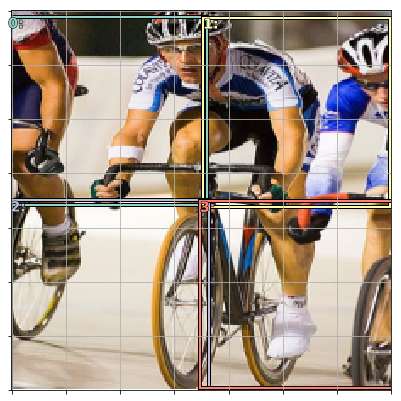

In [30]:
fig, ax = plt.subplots(figsize=(7,7))
show_ground_truth(ax, x[0], a)

# Train

In [49]:
learn.crit = ssd_loss
lr = 1e-2
lrs = np.array([lr/100,lr/10,lr])

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss                           
    0      358.005296 1693384.75



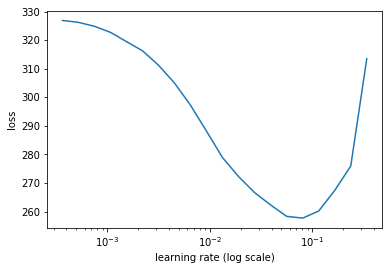

In [50]:
learn.lr_find(lrs/1000,1.)
learn.sched.plot(n_skip_end=2)

In [51]:
learn.fit(lrs, 1, cycle_len=4, use_clr=(20,8))

HBox(children=(IntProgress(value=0, description='Epoch', max=4), HTML(value='')))

epoch      trn_loss   val_loss                           
    0      158.817557 131.366577
    1      126.934596 100.464157                         
    2      109.733197 91.664719                          
    3      98.168986  87.023651                           



[87.02365]

In [52]:
learn.fit(lrs, 1, cycle_len=4, use_clr=(20,8))

HBox(children=(IntProgress(value=0, description='Epoch', max=4), HTML(value='')))

epoch      trn_loss   val_loss                            
    0      96.127282  101.570679
    1      90.684202  86.916367                           
    2      83.812306  82.59671                            
    3      77.56936   79.768166                           



[79.768166]

In [53]:
learn.freeze_to(-2)
learn.fit(lrs/2, 1, cycle_len=4, use_clr=(20,8))

HBox(children=(IntProgress(value=0, description='Epoch', max=4), HTML(value='')))

epoch      trn_loss   val_loss                            
    0      82.647645  98.223877 
    1      79.920943  82.986908                           
    2      72.708604  76.37886                            
    3      66.224075  74.728905                           



[74.728905]

# Testing

In [57]:
def torch_gt(ax, ima, bbox, clas, prs=None, thresh=0.4):
    return show_ground_truth(ax, ima, to_np((bbox*224).long()),
         to_np(clas), to_np(prs) if prs is not None else None, thresh)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


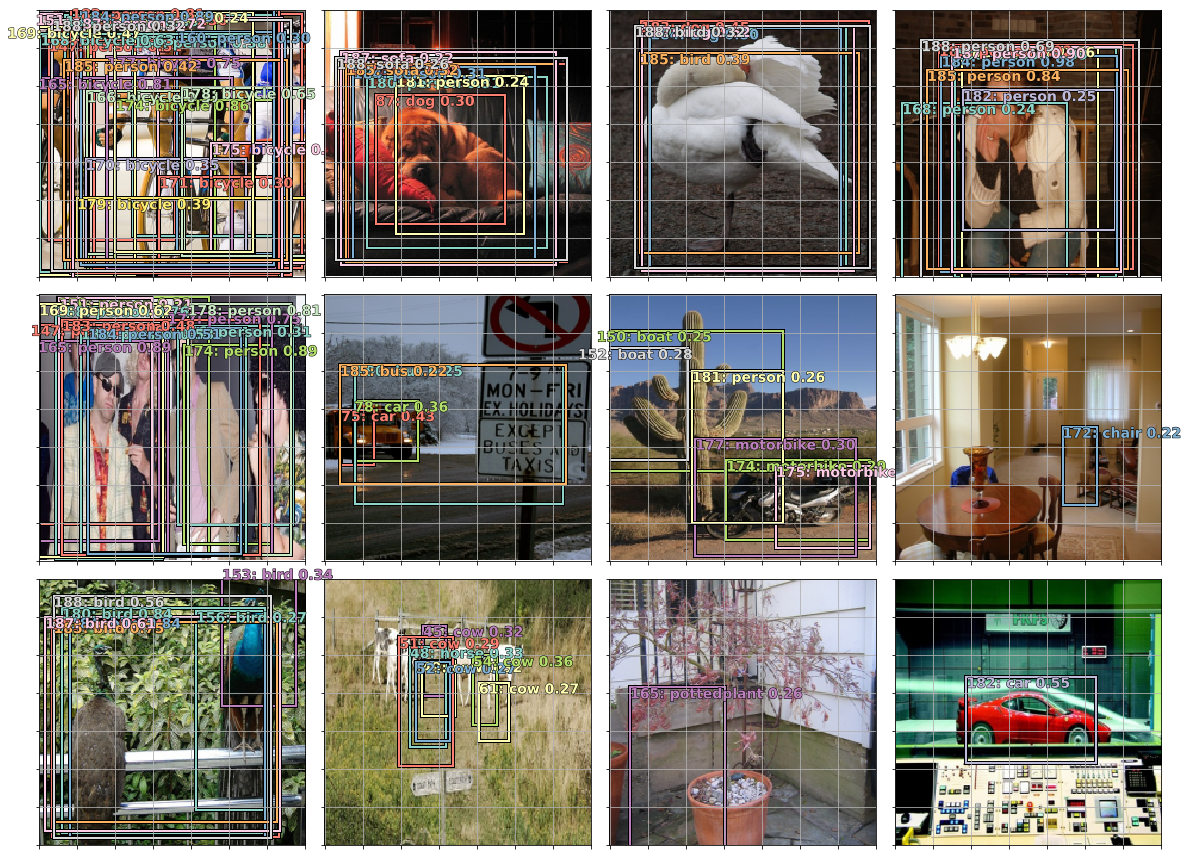

In [58]:
x,y = next(iter(md.val_dl))
y = V(y)
batch = learn.model(V(x))
b_clas,b_bb = batch
x = to_np(x)

fig, axes = plt.subplots(3, 4, figsize=(16, 12))
for idx,ax in enumerate(axes.flat):
    ima=md.val_ds.ds.denorm(x)[idx]
    bbox,clas = get_y(y[0][idx], y[1][idx])
    a_ic = actn_to_bb(b_bb[idx], anchors)
    torch_gt(ax, ima, a_ic, b_clas[idx].max(1)[1], b_clas[idx].max(1)[0].sigmoid(), 0.21)
plt.tight_layout()

# Fix loss problem: Focal loss

In [ ]:
def plot_results(thresh):
    x,y = next(iter(md.val_dl))
    y = V(y)
    batch = learn.model(V(x))
    b_clas,b_bb = batch

    x = to_np(x)
    fig, axes = plt.subplots(3, 4, figsize=(16, 12))
    for idx,ax in enumerate(axes.flat):
        ima=md.val_ds.ds.denorm(x)[idx]
        bbox,clas = get_y(y[0][idx], y[1][idx])
        a_ic = actn_to_bb(b_bb[idx], anchors)
        clas_pr, clas_ids = b_clas[idx].max(1)
        clas_pr = clas_pr.sigmoid()
        torch_gt(ax, ima, a_ic, clas_ids, clas_pr, clas_pr.max().data[0]*thresh)
    plt.tight_layout()

In [59]:
class FocalLoss(BCE_Loss): # inherit BCE loss
    def get_weight(self,x,t):
        '''
        x: prediction (16 or 4 or 1,20), needed to turn into probability through sigmoid
        t: one-hot target (16 or 4 or 1,20), aka y
        
        Return w with size (16 or 4 or 1,20)
        '''
        alpha,gamma = 0.25,1
        p = x.sigmoid()
        pt = p*t + (1-p)*(1-t)
        alpha_t = alpha*t + (1-alpha)*(1-t)
        return alpha_t * (1-pt).pow(gamma)
    


Note that this will be the weight w for 
```
F.binary_cross_entropy_with_logits(x, t, w, size_average=False)/self.num_classes
```

In [ ]:
loss_f = FocalLoss(len(id2cat))

TODO: retrain the model

TODO: Non-Maximum Suppression: take out only the interesting labels and boxes

Will review the different boxes and compares if the boxes overlap a lot (>.5 IOU), and if they predict the same thing. 

Eliminate the duplicate with the lower p-value.